In [1]:
# Original Source : https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/
# Data Source : https://www.kaggle.com/sudalairajkumar/covid19-in-india
# Original Data Source : https://github.com/Praveen76/ANOVA-Test-COVID-19/blob/master/population_india_census2011.csv
# Data Source : https://github.com/Praveen76/ANOVA-Test-COVID-19/blob/master/IndividualDetails.csv

# Part I : Getting Started

## Import Libraries

In [45]:
import pandas as pd
import numpy as np
import os
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.multicomp as multicomp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway

In [2]:
os.getcwd()

'D:\\GitHub\\Python-QuickStart-Codes---Stats-ML-DL-AI-NLP\\Online Sources (Blogs&Articles)'

## Get Datasets

In [3]:
StatewiseTestingDetails=pd.read_csv('./data/covid19_india/StatewiseTestingDetails.csv')
population_india_census2011=pd.read_csv('./data/covid19_india/population_india_census2011.csv')
IndividualDetails=pd.read_csv('./data/covid19_india/IndividualDetails.txt', parse_dates=[2])
print(StatewiseTestingDetails.shape, population_india_census2011.shape, IndividualDetails.shape)

(8066, 5) (36, 8) (27890, 12)


In [4]:
StatewiseTestingDetails.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [5]:
population_india_census2011.head()

,Sno,State,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [6]:
StatewiseTestingDetails['Positive'].sort_values().head()

5270    0.0
5291    0.0
5290    0.0
5289    0.0
5288    0.0
Name: Positive, dtype: float64

In [7]:
StatewiseTestingDetails['Positive'].sort_values(ascending=False).head()

4597    1638961.0
4596    1632544.0
4593    1609516.0
4591    1595381.0
4590    1586321.0
Name: Positive, dtype: float64

In [8]:
StatewiseTestingDetails.loc[4597]

Date             2020-10-24
State           Maharashtra
TotalSamples    8.54804e+06
Negative                NaN
Positive        1.63896e+06
Name: 4597, dtype: object

# Part II : One-Way ANOVA

## MVI

<AxesSubplot:>

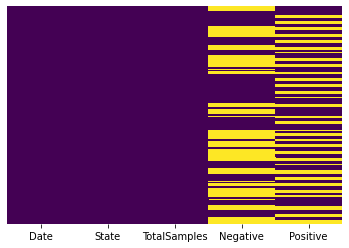

In [9]:
# Visualize missing data
sns.heatmap(StatewiseTestingDetails.isnull(), cmap='viridis', cbar=False, yticklabels=False)

In [10]:
StatewiseTestingDetails['Pos_percent'] = StatewiseTestingDetails['Positive']/StatewiseTestingDetails['TotalSamples']
StatewiseTestingDetails.head()

,Date,State,TotalSamples,Negative,Positive,Pos_percent
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0,0.008553
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0,0.010078
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0,0.011587
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0,0.008791
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0,0.004942


<AxesSubplot:>

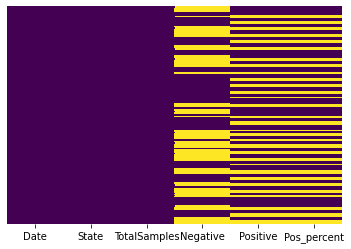

In [11]:
sns.heatmap(StatewiseTestingDetails.isnull(), cmap='viridis', cbar=False, yticklabels=False)

In [12]:
median_pos = StatewiseTestingDetails.groupby('State')[['Pos_percent']].mean().reset_index() \
                                    .rename(columns={'Pos_percent':'Pos_percent_median'})
median_pos.head()

,State,Pos_percent_median
0,Andaman and Nicobar Islands,0.039898
1,Andhra Pradesh,0.026785
2,Arunachal Pradesh,0.008371
3,Assam,0.022474
4,Bihar,0.044050


In [13]:
for index,row in StatewiseTestingDetails.iterrows():
    if pd.isnull(row['Positive']):
        StatewiseTestingDetails['Positive'][index] = int(median_pos[median_pos['State']==row['State']]['Pos_percent_median'] * row['TotalSamples'])
StatewiseTestingDetails.head()

<ipython-input-13-d0ae38fce79b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StatewiseTestingDetails['Positive'][index] = int(median_pos[median_pos['State']==row['State']]['Pos_percent_median'] * row['TotalSamples'])


,Date,State,TotalSamples,Negative,Positive,Pos_percent
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0,0.008553
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0,0.010078
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0,0.011587
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0,0.008791
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0,0.004942


<AxesSubplot:>

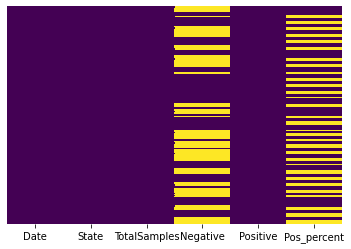

In [14]:
sns.heatmap(StatewiseTestingDetails.isnull(), cmap='viridis', cbar=False, yticklabels=False)

## Merge Datasets

In [15]:
# Merge datasets
data = pd.merge(StatewiseTestingDetails, population_india_census2011, on='State', how='left')
data.shape

(8066, 13)

In [16]:
data.head(3)

,Date,State,TotalSamples,Negative,Positive,Pos_percent,Sno,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0,0.008553,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0,0.010078,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0,0.011587,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876


<AxesSubplot:>

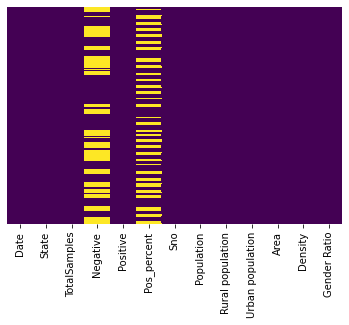

In [17]:
sns.heatmap(data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
# The original census data will have a spelling mistake in 'Telangana' state name.

## Density Buckets for ANOVA

In [19]:
data['Density_int'] = data['Density'].apply(lambda x : float(x.split('/')[0].replace(',','')))
data.tail(3)

,Date,State,TotalSamples,Negative,Positive,Pos_percent,Sno,Population,Rural population,Urban population,Area,Density,Gender Ratio,Density_int
8063,2020-12-06,West Bengal,6135854.0,NaN,308611.0,NaN,4,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,1029.0
8064,2020-12-07,West Bengal,6167307.0,NaN,310193.0,NaN,4,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,1029.0
8065,2020-12-08,West Bengal,6211537.0,NaN,312418.0,NaN,4,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,1029.0


In [20]:
data['density_group'] = 0
for index,row in data.iterrows():
    if row['Density_int']<=300:
        data['density_group'][index] = 'Dense1'
    elif (300<row['Density_int']<=600):
        data['density_group'][index] = 'Dense2'
    elif (600<row['Density_int']<=900):
        data['density_group'][index] = 'Dense3'
    else:
        data['density_group'][index] = 'Dense4'

data['density_group'].value_counts()

<ipython-input-20-ac27bafac4a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['density_group'][index] = 'Dense1'
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-20-ac27bafac4a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['density_group'][index] = 'Dense2'
<ipython-input-20-ac27bafac4a9>:10: SettingWithC

Dense1    3367
Dense2    2821
Dense4    1381
Dense3     497
Name: density_group, dtype: int64

In [103]:
# Data Export to be used further
stateDensity = data[['State', 'density_group']].drop_duplicates().sort_values(by='State')
print(stateDensity.shape)
stateDensity.head()

(35, 2)


,State,density_group
0,Andaman and Nicobar Islands,Dense1
208,Andhra Pradesh,Dense2
451,Arunachal Pradesh,Dense1
681,Assam,Dense2
905,Bihar,Dense4


In [18]:
# data.to_csv('./data/covid19_india/stateDensity.csv')

In [22]:
data[data['Positive']==0].shape

(77, 15)

In [23]:
# If positive cases count is 0, we replace it with 1 to ensure correct data transformations.
data['Positive'] = data['Positive'].apply(lambda x : x if x>0 else 1)

In [24]:
df=pd.DataFrame({'Dense1':data[data['density_group']=='Dense1']['Positive'],
                 'Dense2':data[data['density_group']=='Dense2']['Positive'],
                 'Dense3':data[data['density_group']=='Dense3']['Positive'],
                 'Dense4':data[data['density_group']=='Dense4']['Positive']})
df.shape

(8066, 4)

In [25]:
df.describe()

,Dense1,Dense2,Dense3,Dense4
count,3367.000000,2.821000e+03,497.000000,1381.000000
mean,16980.878824,1.560195e+05,169097.788732,95230.696597
std,34321.099903,2.988721e+05,207156.074814,168534.664502
min,1.000000,2.000000e+00,265.000000,1.000000
25%,468.500000,4.682000e+03,3902.000000,933.000000
50%,2365.000000,3.651900e+04,54183.000000,7511.000000
75%,12043.000000,1.292870e+05,318159.000000,116993.000000
max,198616.000000,1.839783e+06,660205.000000,790869.000000


## One-Way ANOVA Test

#### Normality Assumption

In [26]:
# One of our ANOVA test’s assumptions is that samples should be randomly selected and
# should be close to Gaussian Distribution.
# So let’s select 30 random samples from each factor or level

In [27]:
np.random.seed(7)
dataNew=pd.DataFrame({'Dense1':random.sample(list(data[data['density_group']=='Dense1']['Positive']), 30),
                      'Dense2':random.sample(list(data[data['density_group']=='Dense2']['Positive']), 30),
                      'Dense3':random.sample(list(data[data['density_group']=='Dense3']['Positive']), 30),
                      'Dense4':random.sample(list(data[data['density_group']=='Dense4']['Positive']), 30)})

In [28]:
dataNew.describe()

,Dense1,Dense2,Dense3,Dense4
count,30.000000,3.000000e+01,30.000000,30.000000
mean,5735.900000,1.588011e+05,169302.666667,37600.233333
std,8477.652889,2.788940e+05,215714.162543,71918.457922
min,35.000000,9.110000e+02,265.000000,1.000000
25%,461.500000,5.900750e+03,3558.250000,513.250000
50%,2435.500000,5.350000e+04,29015.000000,2778.500000
75%,5707.750000,1.265120e+05,359106.250000,40863.500000
max,30558.000000,1.097856e+06,599602.000000,288920.000000


<AxesSubplot:title={'center':'density Group -Dense4 & Corona Cases'}, xlabel='density Group -Dense4', ylabel='Corona Cases'>

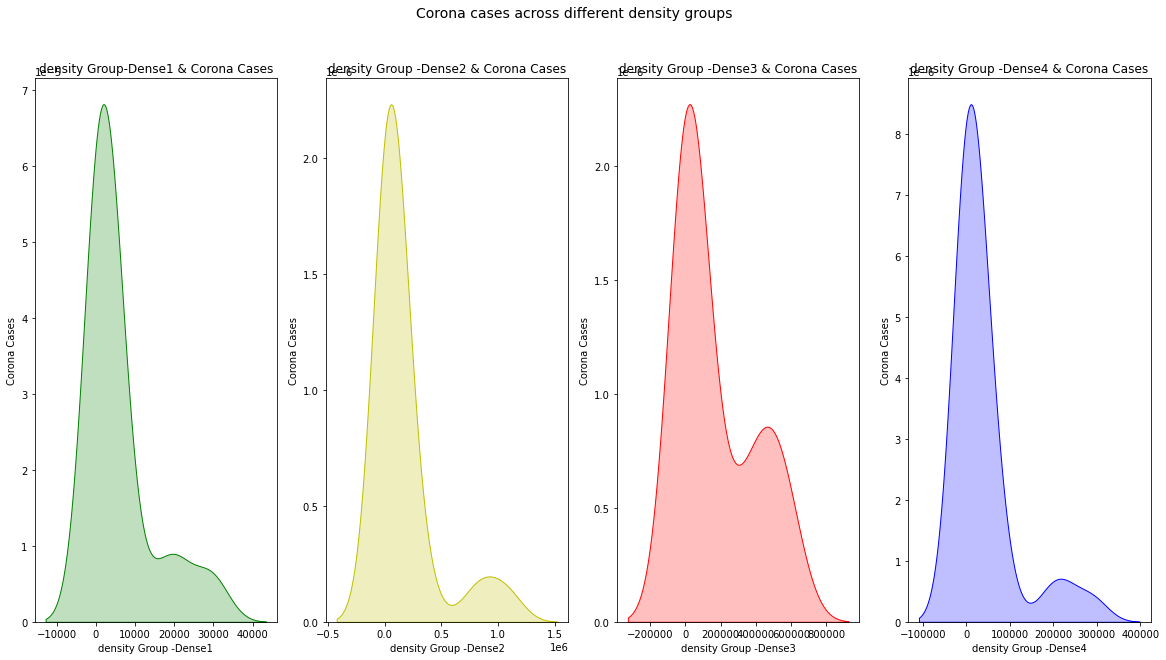

In [29]:
#Plot different density groups
fig = plt.figure(figsize=(20,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
# fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True, color='g')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True, color='y')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title("density Group -Dense3 & Corona Cases")
ax3.set_xlabel("density Group -Dense3")
ax3.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax3, shade=True, color='r')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title("density Group -Dense4 & Corona Cases")
ax4.set_xlabel("density Group -Dense4")
ax4.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax4, shade=True, color='b')

In [30]:
# Normality assumption check (Shapiro-Wilk Test, H0:Normality)
# Further, Skewness and Kurtosis can also be checked for the distributions.
print("Dense1:", stats.shapiro(dataNew['Dense1']))
print("Dense2:", stats.shapiro(dataNew['Dense2']))
print("Dense3:", stats.shapiro(dataNew['Dense3']))
print("Dense4:", stats.shapiro(dataNew['Dense4']))

Dense1: ShapiroResult(statistic=0.6839077472686768, pvalue=9.176016533274378e-07)
Dense2: ShapiroResult(statistic=0.5888317823410034, pvalue=5.3470571970137826e-08)
Dense3: ShapiroResult(statistic=0.7601163387298584, pvalue=1.332621195615502e-05)
Dense4: ShapiroResult(statistic=0.5806795358657837, pvalue=4.275181453294863e-08)


In [31]:
# Homogeneity of Variance assumption check (Levene's Variance Test)
stats.levene(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])
# a p-value of more than 0.05 means variances are equal among groups and we can proceed with ANOVA(and post-hoc if needed)

LeveneResult(statistic=6.596258777332894, pvalue=0.0003727061054247101)

In [32]:
# BoxCox transformation to make it gaussian
dataNew['Dense1'],fitted_lambda1 = stats.boxcox(dataNew['Dense1'])
dataNew['Dense2'],fitted_lambda2 = stats.boxcox(dataNew['Dense2'])
dataNew['Dense3'],fitted_lambda3 = stats.boxcox(dataNew['Dense3'])
dataNew['Dense4'],fitted_lambda4 = stats.boxcox(dataNew['Dense4'])
print(fitted_lambda1, fitted_lambda2, fitted_lambda3, fitted_lambda4)

0.0955107160021047 0.06693334431350978 0.07849784830691199 0.10038340428711941


<AxesSubplot:title={'center':'density Group -Dense4 & Corona Cases'}, xlabel='density Group -Dense4', ylabel='Corona Cases'>

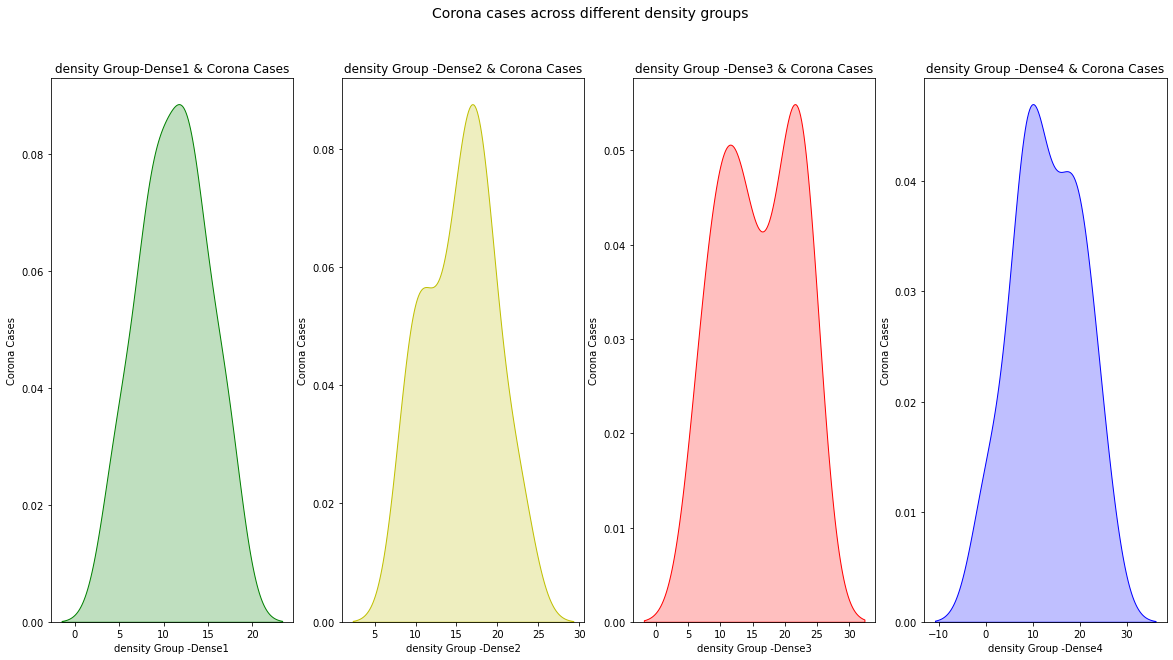

In [33]:
#Plot different density groups
fig = plt.figure(figsize=(20,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
# fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True, color='g')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True, color='y')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title("density Group -Dense3 & Corona Cases")
ax3.set_xlabel("density Group -Dense3")
ax3.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax3, shade=True, color='r')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title("density Group -Dense4 & Corona Cases")
ax4.set_xlabel("density Group -Dense4")
ax4.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax4, shade=True, color='b')

In [34]:
print("Dense1:", stats.shapiro(dataNew['Dense1']))
print("Dense2:", stats.shapiro(dataNew['Dense2']))
print("Dense3:", stats.shapiro(dataNew['Dense3']))
print("Dense4:", stats.shapiro(dataNew['Dense4']))

Dense1: ShapiroResult(statistic=0.9659118056297302, pvalue=0.4341563880443573)
Dense2: ShapiroResult(statistic=0.9528120160102844, pvalue=0.20095974206924438)
Dense3: ShapiroResult(statistic=0.8954072594642639, pvalue=0.006496443413197994)
Dense4: ShapiroResult(statistic=0.9590833187103271, pvalue=0.293447881937027)


In [35]:
stats.levene(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])

LeveneResult(statistic=7.624072180510082, pvalue=0.00010709709536027639)

In [ ]:
# Welch's ANOVA is an alternative to the Classic ANOVA and
# can be used even if your data violates the assumption of homogeneity of variances.

#### Approach 1 : One-Way ANOVA test using statsmodels module

In [36]:
F, p = stats.f_oneway(dataNew['Dense1'], dataNew['Dense2'], dataNew['Dense3'], dataNew['Dense4'])
# To check if the mean is statistically different between any two of the 4 groups:
# (same can be ued to determine if the overall model is significant)
print('F-Statistics:%.8f, p:%.8f' % (F, p))

F-Statistics:5.25048163, p:0.00196536


In [37]:
# The p-value is less than 0.05.
# Hence, we can reject the Null Hypothesis(H0:there are no differences among different density groups).

#### Approach 2 : One-Way ANOVA test using OLS Model

In [38]:
# Rearrange Dataframe
dataNew2 = dataNew.stack().reset_index().rename(columns={'level_1':'density_group', 0:'Count'})
del dataNew2['level_0']
dataNew2.head()

,density_group,Count
0,Dense1,8.684915
1,Dense2,17.872558
2,Dense3,23.392496
3,Dense4,0.717831
4,Dense1,7.914242


In [39]:
# Using the OLS Model
model = ols('Count~C(density_group)', dataNew2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.250
Date:                Tue, 23 Mar 2021   Prob (F-statistic):            0.00197
Time:                        22:14:32   Log-Likelihood:                -370.43
No. Observations:                 120   AIC:                             748.9
Df Residuals:                     116   BIC:                             760.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     11.0954      0.984     11.271      0.000       9.146      13.045
C(density_group)[T.Dense2]     4.3570      1.392      3.130      0.002       1.600       7.114
C(density_group)[T.Dense3]     4.8584      1.392      3.490      0.001       2.101       7.616
C(density_group)[T.Dense4]     1.9256      1.392      1.383      0.169      -0.832       4.683
==============================================================================
Omnibus:                        1.970   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.556
Skew:                          -0.098   Prob(JB):                        0.459
Kurtosis:                       2.478   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .8f}, p = {model.f_pvalue: .8f}")

Overall model F( 3, 116) =  5.25048163, p =  0.00196536


In [41]:
# Creating the ANOVA table
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(density_group),457.946112,3.0,5.250482,0.001965
Residual,3372.500067,116.0,NaN,NaN


In [42]:
# Now we know that there is an overall significant effect of density_group on corona positive cases, but we don't know where.

## Post Hoc Tests (One-Way ANOVA)

In [43]:
# Use Tukey HSD if homogeneity of variances assumption was met.
# If your data did not meet the homogeneity of variances assumption, you should consider running the Games Howell post hoc test.

In [44]:
# We'll use Tukey HSD Test to find out where the group differences are.
mc = multicomp.MultiComparison(dataNew2['Count'], dataNew2['density_group'])
mc_result = mc.tukeyhsd()
print(mc_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Dense1 Dense2    4.357 0.0117  0.7278 7.9862   True
Dense1 Dense3   4.8584 0.0038  1.2291 8.4876   True
Dense1 Dense4   1.9256  0.511 -1.7037 5.5548  False
Dense2 Dense3   0.5014    0.9 -3.1279 4.1306  False
Dense2 Dense4  -2.4314 0.3048 -6.0607 1.1978  False
Dense3 Dense4  -2.9328 0.1572  -6.562 0.6964  False
---------------------------------------------------


In [47]:
# Rejection of null hypothesis in groups(1&2, 1&3) indicate that they have statistically significant differences in means.

#### Assumption Checks/ Model Diagnostics

In [48]:
# When working with linear regression and ANOVA models,
# the assumptions pertain to the residuals and not the variables themselves.

In [49]:
# Normality Assumption Check : Method 1 (Shapiro Wilk)
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9837660193443298, pvalue=0.15880726277828217)

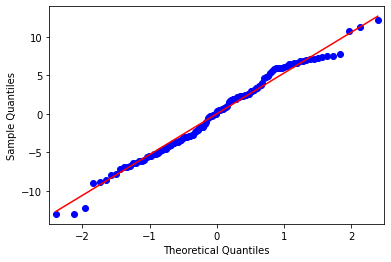

In [50]:
# Normality Assumption Check : Method 2 (Q-Q Plot)
res = model.resid
fig = sm.qqplot(res, line='s')

In [51]:
# Homogeneity of Variance Assumption Check : Using two different methods (Bartlett's Test and Levene's Test)

w, pvalue = stats.bartlett(dataNew2[dataNew2['density_group']=='Dense1']['Count'],
                           dataNew2[dataNew2['density_group']=='Dense2']['Count'],
                           dataNew2[dataNew2['density_group']=='Dense3']['Count'],
                           dataNew2[dataNew2['density_group']=='Dense4']['Count'])
print(w, pvalue)

stats.levene(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])

14.869185908809236 0.0019319205695627203


LeveneResult(statistic=7.624072180510082, pvalue=0.00010709709536027639)

## Part III : Two-Way ANOVA

In [105]:
stateDensity.head(3)

,State,density_group
0,Andaman and Nicobar Islands,Dense1
208,Andhra Pradesh,Dense2
451,Arunachal Pradesh,Dense1


In [54]:
IndividualDetails.head(3)

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan
1,1,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan
2,2,KL-KS-P1,2020-03-02,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan


In [55]:
IndividualDetails[IndividualDetails['age']==0].shape

(0, 12)

In [56]:
IndividualDetails.dtypes

id                             int64
government_id                 object
diagnosed_date        datetime64[ns]
age                           object
gender                        object
detected_city                 object
detected_district             object
State                         object
nationality                   object
current_status                object
status_change_date            object
notes                         object
dtype: object

## MVI

<AxesSubplot:>

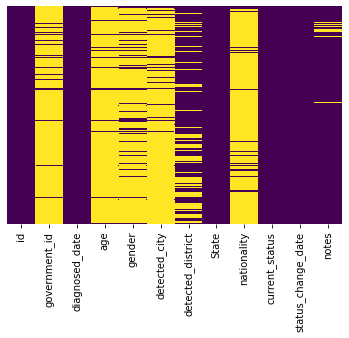

In [57]:
sns.heatmap(IndividualDetails.isnull(), cmap='viridis', cbar=False, yticklabels=False)

In [58]:
print('Percentage of missing values in age & gender columns respectively :', \
      (IndividualDetails['age'].isna().sum()/IndividualDetails.shape[0])*100,'%',\
      (IndividualDetails['gender'].isna().sum()/IndividualDetails.shape[0])*100,'%')

Percentage of missing values in age & gender columns respectively : 91.58838293295088 % 80.95016134815346 %


In [59]:
# Impute age with the median value in each state and gender by mode of male & female in each state

In [60]:
# Transform Age variable into legit integer in order to take the mean.
# There are values like '28-35' and 1.3 in the age column. And missing can't be kept while taking its mean for each state.
for index , row in IndividualDetails.iterrows():
    if not pd.isnull(row['age']):
        if len(row['age'].split('-'))>1:
                    IndividualDetails['age'][index]=round((int(row['age'].split('-')[0])+int(row['age'].split('-')[1]))/2)
        elif len(row['age'].split('.'))>1:    
            IndividualDetails['age'][index]=round(float(row['age']))
        else:
            pass

<ipython-input-60-d468ea882439>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IndividualDetails['age'][index]=round((int(row['age'].split('-')[0])+int(row['age'].split('-')[1]))/2)
<ipython-input-60-d468ea882439>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IndividualDetails['age'][index]=round(float(row['age']))


In [61]:
ageMedianPerState = IndividualDetails[IndividualDetails['age'].notna()]
ageMedianPerState['age'] = ageMedianPerState['age'].astype(int)
ageMedianPerState = ageMedianPerState.groupby('State')[['age']].median().reset_index()
ageMedianPerState['age'] = ageMedianPerState['age'].apply(lambda x:math.ceil(x))
ageMedianPerState.head()

<ipython-input-61-737bb75190e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ageMedianPerState['age']=ageMedianPerState['age'].astype(int)


,State,age
0,Andaman and Nicobar Islands,53
1,Andhra Pradesh,37
2,Assam,52
3,Bihar,31
4,Chandigarh,26


In [72]:
genderModePerState = IndividualDetails.groupby(['State'])['gender'].agg(pd.Series.mode).to_frame().reset_index()
genderModePerState = genderModePerState[genderModePerState['State']!='Arunachal Pradesh']
# Removed the state with no gender info at all.
genderModePerState.head()

,State,gender
0,Andaman and Nicobar Islands,M
1,Andhra Pradesh,M
3,Assam,M
4,Bihar,M
5,Chandigarh,M


In [97]:
#Impute missing values in age & gender columns now
for index, row in IndividualDetails.iterrows():
    if row['State']=='Arunachal Pradesh':
        IndividualDetails.drop([index],inplace=True)
        continue
    if pd.isnull(row['age']):
        IndividualDetails['age'][index]=ageMedianPerState[ageMedianPerState['State']==row['State']]['age'].values[0]
    if pd.isnull(row['gender']):
        if len(genderModePerState[genderModePerState['State']==row['State']]['gender'].values)>0:
            IndividualDetails['gender'][index]=(genderModePerState[genderModePerState['State']==row['State']]['gender'].values[0])

<ipython-input-97-45c3fb259c70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IndividualDetails['age'][index]=ageMedianPerState[ageMedianPerState['State']==row['State']]['age'].values[0]
<ipython-input-97-45c3fb259c70>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IndividualDetails['gender'][index]=(genderModePerState[genderModePerState['State']==row['State']]['gender'].values[0])


In [98]:
IndividualDetails.isna().sum()

id                        0
government_id         24892
diagnosed_date            0
age                       0
gender                    0
detected_city         25542
detected_district      7650
State                     0
nationality           25183
current_status            0
status_change_date      110
notes                  1335
dtype: int64

## Merge Datasets

In [109]:
# Merge individualDetails & stateDensity dataframes
data_w2=pd.merge(IndividualDetails,stateDensity,on='State',how='left').reset_index(drop=True)
print(data_w2.shape)
data_w2.head()

(27889, 13)


,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes,density_group
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
1,1,KL-AL-P1,2020-02-02,35,M,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
2,2,KL-KS-P1,2020-03-02,35,M,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
3,3,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15-03-2020,"Travelled from Austria, Italy",Dense4
4,4,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02-03-2020,"Travelled from Dubai to Bangalore on 20th Feb,...",Dense2


In [110]:
data_w2.dropna()

id                        0
government_id         24892
diagnosed_date            0
age                       0
gender                    0
detected_city         25542
detected_district      7650
State                     0
nationality           25183
current_status            0
status_change_date      110
notes                  1335
density_group             0
dtype: int64

## Age Buckets and Data Prep. for ANOVA

In [112]:
data_w2['age_group']=0
for index, row in data_w2.iterrows():
    i=float(row['age'])
    if 0<i<=20:
        data_w2['age_group'][index]='Young'
    elif 20<i<=40:
        data_w2['age_group'][index]='Adult'
    else:
        data_w2['age_group'][index]='Old'

data_w2['age_group'].value_counts()

<ipython-input-112-be28fd22d9cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w2['age_group'][index]='Young'
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-112-be28fd22d9cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w2['age_group'][index]='Adult'
<ipython-input-112-be28fd22d9cf>:9: SettingWithCopyWar

Old      15566
Adult    11917
Young      406
Name: age_group, dtype: int64

In [117]:
patient_Count=data_w2.groupby(['diagnosed_date', 'density_group'])[['diagnosed_date']].count().\
                      rename(columns={'diagnosed_date':'Count'}).reset_index()
patient_Count.head(7)

,diagnosed_date,density_group,Count
0,2020-01-04,Dense1,67
1,2020-01-04,Dense2,281
2,2020-01-04,Dense3,37
3,2020-01-04,Dense4,39
4,2020-01-30,Dense3,1
5,2020-02-02,Dense3,1
6,2020-02-03,Dense2,1


In [122]:
data_tmp=pd.merge(data_w2, patient_Count, on=['diagnosed_date', 'density_group'], how='inner')
data_tmp.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes,density_group,age_group,Count
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Young,1
1,1,KL-AL-P1,2020-02-02,35,M,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Adult,1
2,2,KL-KS-P1,2020-03-02,35,M,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Adult,1
3,3,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15-03-2020,"Travelled from Austria, Italy",Dense4,Old,1
4,4,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02-03-2020,"Travelled from Dubai to Bangalore on 20th Feb,...",Dense2,Adult,1


In [125]:
#Rearrange Dataframe
newData=data_tmp.groupby(['density_group','age_group'])['Count'].apply(list).reset_index()
print(newData.shape)
newData.head()

(12, 3)


,density_group,age_group,Count
0,Dense1,Adult,"[1, 1, 1, 2, 2, 5, 4, 4, 6, 6, 6, 16, 16, 16, ..."
1,Dense1,Old,"[1, 1, 2, 2, 1, 1, 1, 5, 5, 5, 5, 4, 6, 6, 16,..."
2,Dense1,Young,"[4, 6, 18, 18, 27, 27, 32, 11, 41, 84, 191, 19..."
3,Dense2,Adult,"[1, 6, 5, 5, 5, 5, 10, 10, 7, 9, 9, 8, 8, 8, 1..."
4,Dense2,Old,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


## Two-Way ANOVA Test

In [139]:
#Select random samples of each category
np.random.seed(708)
AnovaData = pd.DataFrame(columns=['density_group','age_group','Count'])
for index,row in newData.iterrows():
    count = 17
    tempDf = pd.DataFrame(index=range(0,count), columns=['density_group','age_group','Count'])
    
    tempDf['age_group'] = newData['age_group'][index]
    tempDf['density_group'] = newData['density_group'][index]
    tempDf['Count'] = random.sample(list(newData['Count'][index]),count)
    AnovaData = pd.concat([AnovaData,tempDf],axis=0)

In [166]:
AnovaData['Count'] = AnovaData['Count'].astype(int)

In [167]:
AnovaData.dtypes

density_group    object
age_group        object
Count             int32
dtype: object

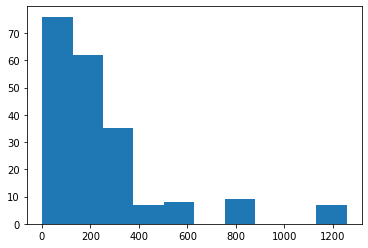

In [168]:
plt.hist(AnovaData['Count'])
plt.show()

<AxesSubplot:xlabel='Count', ylabel='Density'>

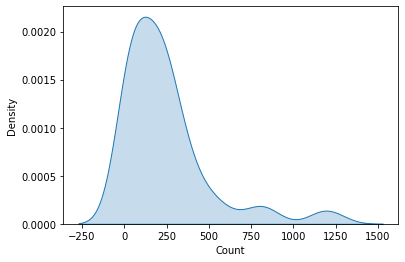

In [169]:
sns.kdeplot(AnovaData['Count'], shade=True)

<AxesSubplot:xlabel='age_group', ylabel='Count'>

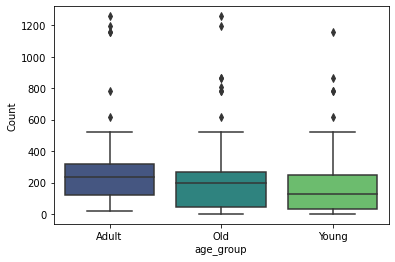

In [173]:
#Check for outliers
sns.boxplot(x='age_group', y='Count', data=AnovaData, palette="viridis")

In [174]:
# Box Cox Transformation to get a normal data
AnovaData['newCount'], fitted_lambda = stats.boxcox(AnovaData['Count'])

<AxesSubplot:xlabel='newCount', ylabel='Density'>

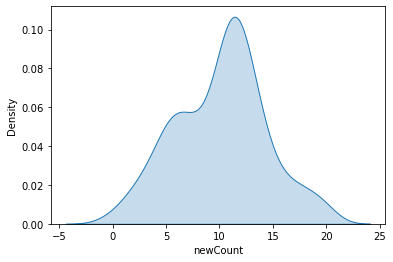

In [176]:
sns.kdeplot(AnovaData['newCount'], shade=True)

#### Approach 1 - Fit the OLS Model

In [177]:
model2 = ols('newCount ~ C(age_group) + C(density_group)', AnovaData).fit()

print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")
model2.summary()

Overall model F( 5.0, 198.0) =  38.76612635540874, p =  1.2001177831208807e-27


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     38.77
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           1.20e-27
Time:                        02:01:44   Log-Likelihood:                -513.47
No. Observations:                 204   AIC:                             1039.
Df Residuals:                     198   BIC:                             1059.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     11.1483      0.522     21.359      0.000      10.119      12.178
C(age_group)[T.Old]           -1.3127      0.522     -2.515      0.013      -2.342      -0.283
C(age_group)[T.Young]         -2.4666      0.522     -4.726      0.000      -3.496      -1.437
C(density_group)[T.Dense2]     4.0379      0.603      6.700      0.000       2.849       5.226
C(density_group)[T.Dense3]    -3.8146      0.603     -6.329      0.000      -5.003      -2.626
C(density_group)[T.Dense4]     0.7087      0.603      1.176      0.241      -0.480       1.897
==============================================================================
Omnibus:                       33.094   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.217
Skew:                          -0.903   Prob(JB):                     7.56e-12
Kurtosis:                       4.662   Cond. No.                         5.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
# Generate the ANOVA table
sm.stats.anova_lm(model2, typ=2)

,sum_sq,df,F,PR(>F)
C(age_group),207.137846,2.0,11.181814,2.506124e-05
C(density_group),1588.172873,3.0,57.155668,1.168327e-26
Residual,1833.928513,198.0,NaN,NaN


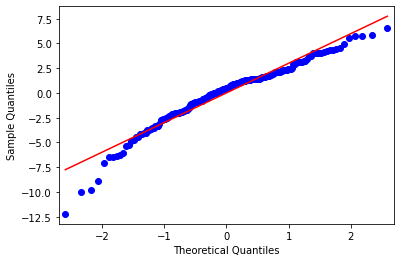

In [179]:
#Check the Normal distribution of residuals (Q-Q Plot)
res = model2.resid 
fig = sm.qqplot(res, line='s')
plt.show()

#### Approach 2 - Check the interactions of groups

In [180]:
formula = 'newCount ~ C(age_group) *C(density_group)'
model3 = ols(formula, AnovaData).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     19.90
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           2.09e-26
Time:                        02:08:19   Log-Likelihood:                -505.47
No. Observations:                 204   AIC:                             1035.
Df Residuals:                     192   BIC:                             1075.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           11.6446      0.721     16.156      0.000      10.223      13.066
C(age_group)[T.Old]                                 -0.9594      1.019     -0.941      0.348      -2.970       1.051
C(age_group)[T.Young]                               -4.3087      1.019     -4.227      0.000      -6.319      -2.298
C(density_group)[T.Dense2]                           3.4630      1.019      3.397      0.001       1.452       5.474
C(density_group)[T.Dense3]                          -4.0248      1.019     -3.948      0.000      -6.035      -2.014
C(density_group)[T.Dense4]                          -0.4915      1.019     -0.482      0.630      -2.502       1.519
C(age_group)[T.Old]:C(density_group)[T.Dense2]       0.4430      1.442      0.307      0.759      -2.400       3.286
C(age_group)[T.Young]:C(density_group)[T.Dense2]     1.2816      1.442      0.889      0.375      -1.562       4.125
C(age_group)[T.Old]:C(density_group)[T.Dense3]      -1.9862      1.442     -1.378      0.170      -4.830       0.857
C(age_group)[T.Young]:C(density_group)[T.Dense3]     2.6167      1.442      1.815      0.071      -0.227       5.460
C(age_group)[T.Old]:C(density_group)[T.Dense4]       0.1301      1.442      0.090      0.928      -2.713       2.973
C(age_group)[T.Young]:C(density_group)[T.Dense4]     3.4705      1.442      2.407      0.017       0.627       6.314
==============================================================================
Omnibus:                       35.404   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.580
Skew:                          -0.853   Prob(JB):                     1.28e-15
Kurtosis:                       5.271   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
aov_table = anova_lm(model3, typ=2)
print(aov_table.round(4))

                                  sum_sq     df        F  PR(>F)
C(age_group)                    207.1378    2.0  11.7266  0.0000
C(density_group)               1588.1729    3.0  59.9403  0.0000
C(age_group):C(density_group)   138.1901    6.0   2.6078  0.0188
Residual                       1695.7384  192.0      NaN     NaN


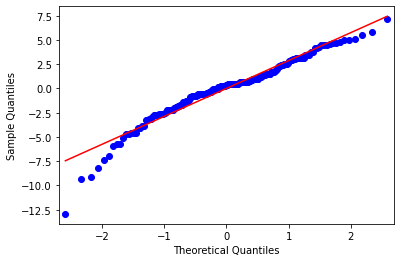

In [185]:
res = model3.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [ ]:
# The P-value obtained from ANOVA analysis for the number of Corona cases, age group and
# density group and interaction are statistically significant (P < 0.05).
# We conclude that type of density_Group significantly affects the corona case outcome.

#### Approach 3 - Combined approach (1+2)

In [186]:
formula = 'newCount ~ C(age_group) + C(density_group) + C(age_group):C(density_group)'
model4 = ols(formula, AnovaData).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     19.90
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           2.09e-26
Time:                        02:13:54   Log-Likelihood:                -505.47
No. Observations:                 204   AIC:                             1035.
Df Residuals:                     192   BIC:                             1075.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           11.6446      0.721     16.156      0.000      10.223      13.066
C(age_group)[T.Old]                                 -0.9594      1.019     -0.941      0.348      -2.970       1.051
C(age_group)[T.Young]                               -4.3087      1.019     -4.227      0.000      -6.319      -2.298
C(density_group)[T.Dense2]                           3.4630      1.019      3.397      0.001       1.452       5.474
C(density_group)[T.Dense3]                          -4.0248      1.019     -3.948      0.000      -6.035      -2.014
C(density_group)[T.Dense4]                          -0.4915      1.019     -0.482      0.630      -2.502       1.519
C(age_group)[T.Old]:C(density_group)[T.Dense2]       0.4430      1.442      0.307      0.759      -2.400       3.286
C(age_group)[T.Young]:C(density_group)[T.Dense2]     1.2816      1.442      0.889      0.375      -1.562       4.125
C(age_group)[T.Old]:C(density_group)[T.Dense3]      -1.9862      1.442     -1.378      0.170      -4.830       0.857
C(age_group)[T.Young]:C(density_group)[T.Dense3]     2.6167      1.442      1.815      0.071      -0.227       5.460
C(age_group)[T.Old]:C(density_group)[T.Dense4]       0.1301      1.442      0.090      0.928      -2.713       2.973
C(age_group)[T.Young]:C(density_group)[T.Dense4]     3.4705      1.442      2.407      0.017       0.627       6.314
==============================================================================
Omnibus:                       35.404   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.580
Skew:                          -0.853   Prob(JB):                     1.28e-15
Kurtosis:                       5.271   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Post Hoc Tests (Two-Way ANOVA)

In [188]:
mc = multicomp.MultiComparison(AnovaData['newCount'],AnovaData['density_group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Dense1 Dense2   4.0379  0.001  2.3988  5.6769   True
Dense1 Dense3  -3.8146  0.001 -5.4536 -2.1755   True
Dense1 Dense4   0.7087 0.6571 -0.9303  2.3478  False
Dense2 Dense3  -7.8525  0.001 -9.4915 -6.2134   True
Dense2 Dense4  -3.3292  0.001 -4.9682 -1.6901   True
Dense3 Dense4   4.5233  0.001  2.8843  6.1624   True
----------------------------------------------------


In [190]:
mc = multicomp.MultiComparison(AnovaData['newCount'],AnovaData['age_group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Adult    Old  -1.3127 0.1548 -2.9836  0.3583  False
 Adult  Young  -2.4666 0.0017 -4.1375 -0.7956   True
   Old  Young  -1.1539 0.2354 -2.8249  0.5171  False
----------------------------------------------------
